In [1]:
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import lasagne
import pickle

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 4007)


# Read and preprocess the data

In [2]:
# reading CSV file
reader = csv.reader(open('data/SL2.csv', 'r'), delimiter=',')
train = np.array(list(reader))
reader = csv.reader(open('data/PL.csv', 'r'), delimiter=',')
test = np.array(list(reader))

In [3]:
print train

[['' '' '' ..., '' '' '']
 ['Date' 'Day of the week' '1-workday, 2-Saturday, 3-Sunday, >4-untypical'
  ..., 'Hour 22' 'Hour 23' 'Hour 24']
 ['19990101' '5' '4.01' ..., '364431' '357204' '324412']
 ..., 
 ['20011229' '6' '2' ..., '431338' '412652' '376991']
 ['20011230' '7' '3' ..., '432592' '414905' '370274']
 ['20011231' '1' '4.13' ..., '408512' '403538' '383141']]


In [4]:
labels = test[1,:]
print labels

['Date' 'Day of the week' '1-workday, 2-Saturday, 3-Sunday, >4-untypical'
 'Hour 1' 'Hour 2' 'Hour 3' 'Hour 4' 'Hour 5' 'Hour 6' 'Hour 7' 'Hour 8'
 'Hour 9' 'Hour 10' 'Hour 11' 'Hour 12' 'Hour 13' 'Hour 14' 'Hour 15'
 'Hour 16' 'Hour 17' 'Hour 18' 'Hour 19' 'Hour 20' 'Hour 21' 'Hour 22'
 'Hour 23' 'Hour 24']


In [5]:
train = np.delete(train, [0,1], 0)
date_train = train[0, :]
weekday_train = train[1, :]
day_type_train = train[2, :]
train_set = np.delete(train, [0,1,2], 1)

In [6]:
test = np.delete(test, [0,1], 0)
date_test = test[0, :]
weekday_test = test[1, :]
day_type_test = test[2, :]
test_set = np.delete(test, [0,1,2], 1)

In [7]:
train_set = np.array(train_set, dtype='float32')
test_set = np.array(test_set, dtype='float32')

In [8]:
train_set = np.reshape(train_set, train_set.shape[0]*train_set.shape[1])
test_set = np.reshape(test_set, test_set.shape[0]*test_set.shape[1])

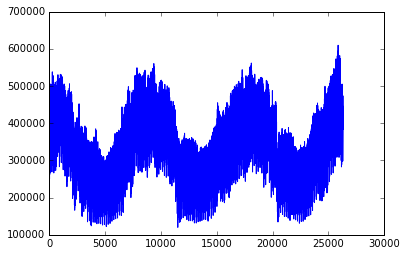

In [9]:
plt.plot(train_set)

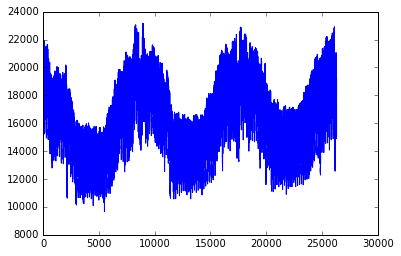

In [10]:
plt.plot(test_set)

In [11]:
def sample_random_batches(source,n_batches=10, seq_len=20):
    """
    This function takes random subsequences from the time series.

    Parameters:
        source - initial time series
        n_batches - how many subsequences are to be sampled
        seq_len - length of each of such subsequences
        
    
    Return:
     X - a matrix of float32 with shape [n_batches,seq_len]
        Each row of such matrix must be a subsequence of source 
            starting from random index (from 0 to N-seq_len-2)
     Y - a vector, where i-th number is one going RIGHT AFTER i-th row from X from source
     
    """
    
    X_batch = np.zeros(shape=(n_batches, seq_len))
    y_batch = np.zeros(shape=(n_batches, 1))
    for i in range(n_batches):
        k = np.random.randint(0, len(source)-seq_len-1)
        X_batch[i] = source[k:k+seq_len]
        y_batch[i] = source[k+seq_len]
    
    return X_batch, y_batch

# Constants

In [12]:
#Training sequence length
seq_length = 100

#max gradient between recurrent layer applications
grad_clip = 100

#values to be predicted
pred_len = 1

# Input values

In [13]:
input_sequence = T.matrix('input sequence')
target_values = T.matrix('target y')

# Neural network architecture

In [14]:

l_in = lasagne.layers.InputLayer(shape=(None, seq_length),input_var=input_sequence)

l1 = lasagne.layers.ExpressionLayer(l_in, lambda X: X.mean(axis=1), output_shape=(None, 1))
l1 = lasagne.layers.ReshapeLayer(l1, shape=(-1, 1))

l2 = lasagne.layers.ExpressionLayer(l_in, lambda X: X.std(axis=1), output_shape=(None, 1))
l2 = lasagne.layers.ReshapeLayer(l2, shape=(-1, 1))

l3 = lasagne.layers.ExpressionLayer(l_in, lambda X: 
                                    ((X.reshape([1, X.shape[0]*X.shape[1]]) - T.repeat(X.mean(axis=1), seq_length))/
                                     T.repeat(X.std(axis=1), seq_length)).reshape(X.shape),
                                    output_shape=(None, seq_length))

l4 = lasagne.layers.ReshapeLayer(l3, shape=(-1, seq_length, 1))

#l_rnn = lasagne.layers.RecurrentLayer(l4, num_units=50, grad_clipping=grad_clip, 
#                                      nonlinearity=lasagne.nonlinearities.tanh)
#l_rnn = lasagne.layers.RecurrentLayer(l_rnn, num_units=25, grad_clipping=grad_clip, 
#                                      nonlinearity=lasagne.nonlinearities.tanh)
l_rnn = lasagne.layers.LSTMLayer(l4, num_units=50, grad_clipping=grad_clip, 
                                    nonlinearity=lasagne.nonlinearities.tanh)
l_rnn = lasagne.layers.LSTMLayer(l_rnn, num_units=25, grad_clipping=grad_clip, 
                                    nonlinearity=lasagne.nonlinearities.tanh)
#l_slice = lasagne.layers.SliceLayer(l_rnn, -1, 1)
#l_dense = lasagne.layers.BatchNormLayer(l_slice)
#l_dense = lasagne.layers.DenseLayer(l_dense, num_units=20, nonlinearity=lasagne.nonlinearities.tanh)
#l_dense = lasagne.layers.BatchNormLayer(l_dense)
#l_dense = lasagne.layers.DenseLayer(l_dense, num_units=10, nonlinearity=lasagne.nonlinearities.tanh)
#l_dense = lasagne.layers.BatchNormLayer(l_dense)

l_out_norm = lasagne.layers.DenseLayer(l_rnn, num_units=pred_len, nonlinearity=lasagne.nonlinearities.linear)

l_out_mul = lasagne.layers.ElemwiseMergeLayer([l_out_norm, l2], merge_function = T.mul)
l_out = lasagne.layers.ElemwiseSumLayer([l_out_mul, l1])

In [15]:
#a = theano.function([input_sequence], lasagne.layers.get_output(l4))

In [16]:
#print a([train_set[0:200], train_set[200:400]])

In [17]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print weights

[W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b]


In [18]:
network_output = lasagne.layers.get_output(l_out)
#If you use dropout do not forget to create deterministic version for evaluation

In [19]:
network_output_norm = lasagne.layers.get_output(l_out_norm)

In [20]:
loss = T.mean(lasagne.objectives.squared_error(network_output, target_values))

#updates = lasagne.updates.nesterov_momentum(loss, weights, learning_rate=2e-4, momentum=0.9)
updates = lasagne.updates.adam(loss, weights, learning_rate=2e-4)

# Compiling all functions

In [21]:
#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

# next character probabilities
forecast = theano.function([input_sequence],network_output,allow_input_downcast=True)

# Function for saving trained parameters

In [22]:
def checkpoint(name):
    params = lasagne.layers.get_all_param_values(l_out)
    pickle.dump(params, open(name, 'wb'))

# Training loop

In [34]:

print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 100

#how many training sequences are processed in a single function call
batch_size=100


for epoch in xrange(n_epochs):

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_random_batches(train_set,batch_size,seq_length)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))


Training ...
Epoch 0 average loss = 109242418.52
Epoch 1 average loss = 106903219.4
Epoch 2 average loss = 102289761.8
Epoch 3 average loss = 109360837.96
Epoch 4 average loss = 112198658.72
Epoch 5 average loss = 107616303.84
Epoch 6 average loss = 108906229.8
Epoch 7 average loss = 113084347.96
Epoch 8 average loss = 107554513.96
Epoch 9 average loss = 105951124.12
Epoch 10 average loss = 109019693.16
Epoch 11 average loss = 114390646.36
Epoch 12 average loss = 129501091.92
Epoch 13 average loss = 140063325.68
Epoch 14 average loss = 137315299.68
Epoch 15 average loss = 138690633.92
Epoch 16 average loss = 158072754.08
Epoch 17 average loss = 125426633.84
Epoch 18 average loss = 116651909.84
Epoch 19 average loss = 121653485.12
Epoch 20 average loss = 109886074.52
Epoch 21 average loss = 111840961.04
Epoch 22 average loss = 113225423.92
Epoch 23 average loss = 106781624.2
Epoch 24 average loss = 108942925.08
Epoch 25 average loss = 108098109.52
Epoch 26 average loss = 108378272.68
Ep

# Testing perfomance

In [65]:
print("Testing ...")

test_seq_len = 220

x,y = sample_random_batches(test_set,1,test_seq_len)
x_forecast = np.zeros((1, test_seq_len))
x_cur = np.zeros((1, seq_length))
x_forecast[:, 0:seq_length] = x[:, 0:seq_length] 

for start in xrange(test_seq_len-seq_length):

    x_cur = x_forecast[:, start:start+seq_length]
    x_forecast[:, start+seq_length] = forecast(x_cur)


Testing ...


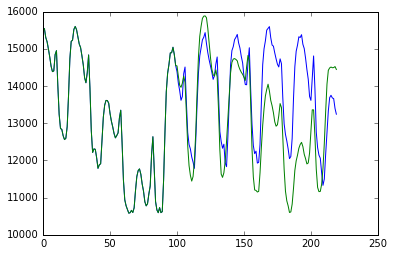

In [66]:
plt.plot(x[0])
plt.plot(x_forecast[0])

In [67]:
checkpoint('Version 2.0')

In [68]:

print("Testing ...")

n_test_runs = 100
avg_cost = 0;
    
for epoch in xrange(n_test_runs):

    x,y = sample_random_batches(test_set,1,seq_length)
    avg_cost = avg_cost + (y - forecast(x))**2
    
print("Average loss {} on {} test runs".format(avg_cost / n_test_runs, n_test_runs))


Testing ...
Average loss [[ 271980.73430112]] on 100 test runs
